# Lets create a Recommendation system for the Henry coefficients of porous materials

In [289]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import scipy
from scipy.sparse.linalg import svds
import tensorflow as tf

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [3]:
henry_df = pd.read_csv('data/henry_matrix_df.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,MWUXSHHQAYIFBG-UHFFFAOYSA-N_298K,XLYOFNOQVPJJNP-UHFFFAOYSA-N_298K,...,VGGSQFUCUMXWEO-UHFFFAOYSA-N_298K,QGZKDVFQNNGYKY-UHFFFAOYSA-N_298K,CSCPPACGZOOCGX-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,NNPPMTNAJDCUHE-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.627878,0.208338,0.240586,NaN,13.210824,15.439162,0.001502,3.488718,NaN,9.316021,...,1.370187,0.958055,NaN,NaN,NaN,NaN,NaN,NaN,18.192574,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,14.439543,0.613339,0.770274,0.096864,52.095266,80.817935,NaN,NaN,NaN,NaN,...,3.116040,442.583688,NaN,257.522347,NaN,NaN,NaN,NaN,NaN,97.061748
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.982443,0.286726,0.058081,0.188162,NaN,NaN,NaN,3.694219,NaN,2.344581,...,40.043567,1.409460,1.462035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,2.198198,0.206994,0.735486,0.097778,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,66.204409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.358242,0.250075,0.606177,0.238141,478.099058,25.528800,86.774658,0.077938,10.083501,2315.499440,...,36.576317,362.456884,NaN,0.267295,386.886107,NaN,NaN,NaN,34.533257,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,3.040278,NaN,14.129264,NaN,NaN,NaN,51.060147,7.839395,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.104883,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.015902,0.175303,0.351781,NaN,NaN,0.219119,1.156680,0.072082,0.171605,0.306919,...,NaN,37.412808,NaN,NaN,NaN,NaN,NaN,NaN,16.823514,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,2.449089,0.195309,0.599994,0.122395,NaN,NaN,NaN,0.720796,NaN,493.780606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-0d52b4312e8dd98a53fcfaba14cd0e82,NaN,NaN,NaN,NaN,124.576242,88.002547,NaN,1.429994,NaN,52.073153,...,NaN,NaN,NaN,224.890244,NaN,NaN,NaN,NaN,NaN,125.484691


In [735]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [748]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, np.nan, dtype=np.double)
    col_bool = True
    n_col = 0
    while col_bool:
        n_col += 1
        col_bool = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.int(np.random.rand()*k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            vals = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(vals[~np.isnan(vals)]) < k:
                #print(j_col)
                col_bool = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_col > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_col))
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e4)

Number of iterations required to split data into 3-folds: 13


In [749]:
fold_matrix

array([[ 2.,  1.,  1., ..., nan,  2., nan],
       [ 2.,  0.,  1., ..., nan, nan,  1.],
       [ 0.,  1.,  2., ..., nan, nan, nan],
       ...,
       [ 2., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [754]:
henry_df.mask(fold_matrix != 0).values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.6133393 ,        nan, ...,        nan,        nan,
               nan],
       [0.98244338,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

### Lets start setting up the Recommender System algorithm

In [537]:
def predict(x, y, mu, b_i, b_u):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + b_i + b_u + (x.T).dot(y)

In [538]:
def predict_all(X, Y, mu, b_i, b_u):
    predictions = np.zeros((X.shape[1], Y.shape[1]))
    for u in range(X.shape[1]):
        for i in range(Y.shape[1]):
            predictions[u, i] = predict(X[:,u], Y[:,i], mu, b_i[i], b_u[u])
    return predictions

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

X_shape: (20, 86)	Y_shape: (20, 27)
Train Error on iteration 0: 27.890600842915152
-------------
Train Error on iteration 1000: 2.09894538921504
-------------
Training has converged after 1239 iterations. See `convergence` parameter for convergence procedure.
Train error: 2.1007027157223805


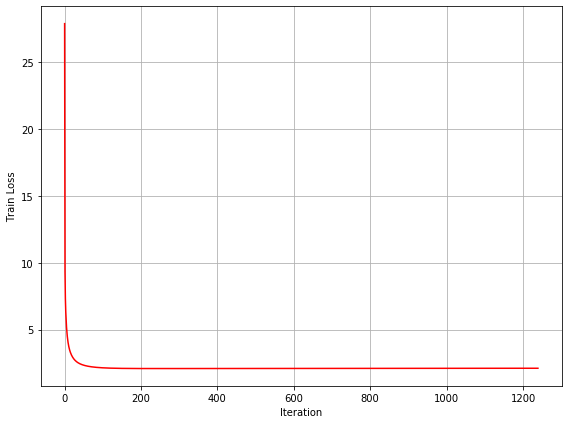

In [842]:
def ALS(henry_matrix, f, lambd, threshold, convergence=1e-5, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    mu = np.nanmean(henry_matrix)
    b_i = np.nanmean(henry_matrix, axis=0) - mu
    b_u = np.nanmean(henry_matrix, axis=1) - mu
    
    M = (np.random.rand(f, henry_matrix.shape[0])-0.5)*0.1
    G = (np.random.rand(f, henry_matrix.shape[1])-0.5)*0.1
    print('X_shape: {}\tY_shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for j in range(M.shape[1]):
            B = mu + b_u[j] + b_i
            mask = ~np.isnan(henry_matrix[j,:])
            try:
                z = np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd * np.identity(f))
            except Exception as e:
                print(G[:,mask].dot(G[:,mask].T))
                raise Exception(e)
            M[:,j] = ((henry_matrix[j,:][mask]-B[mask]).dot(G[:,mask].T)).dot(np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd * np.identity(f)))
        for j in range(G.shape[1]):
            B = mu + b_i[j] + b_u
            mask = ~np.isnan(henry_matrix[:,j])
            G[:,j] = np.linalg.inv(M[:,mask].dot(M[:,mask].T) + lambd * np.identity(f)).dot(M[:,mask]).dot(henry_matrix[:,j][mask]-B[mask])
                
        #print(tf.math.subtract(henry_matrix, tf.matmul(np.transpose(X), Y)))
        pred = predict_all(M, G, mu, b_i, b_u)[~np.isnan(henry_matrix)].flatten()
        actual = henry_matrix[~np.isnan(henry_matrix)].flatten()
        #print(pred)
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return M, G, mu, b_i, b_u
p,q,mu,b_i,b_u = ALS(henry_df.values, 20, 10.3, 1e-5)

In [941]:
h = p.T.dot(q)
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {}'.format(h[i,j] + mu + b_i[j] + b_u[i]))
    print('Actual value: {}\n'.format(henry_df.values[i,j]))

Adsorption of Carbon monoxide in MOF-74
Prediction: -34.81207707649958
Actual value: nan

Adsorption of Sulfur dioxide in Zeolite BEA
Prediction: 89.24261421779524
Actual value: nan

Adsorption of Oxygen in Mg-MOF-74
Prediction: -70.69349722573614
Actual value: nan

Adsorption of Ethene in Zn(bdc)(ted)0.5
Prediction: -21.55651306304881
Actual value: nan

Adsorption of Ethanol in COMOC-2
Prediction: 189.30118174811665
Actual value: nan

Adsorption of Oxygen in Zeolite ISV
Prediction: 2.8817388990919
Actual value: nan

Adsorption of Benzene in Y-ftw-MOF-2
Prediction: 0.5773971997189733
Actual value: nan

Adsorption of Carbon monoxide in Sc3(Me-BTC)2(OH)3
Prediction: -27.78091015971168
Actual value: nan

Adsorption of Argon in ZIF-71
Prediction: -24.910285968051056
Actual value: nan

Adsorption of 1-Propanol in Cu-MOF
Prediction: -8.18278178932411
Actual value: nan



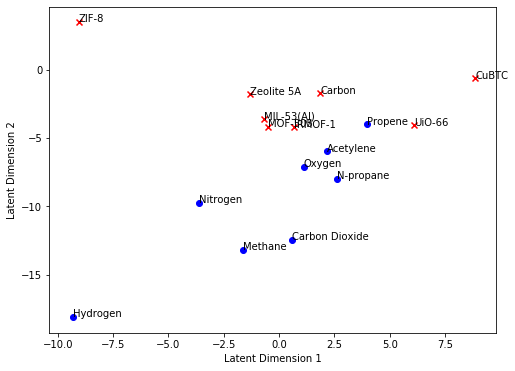

In [790]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(p[0,:n], p[1,:n], color='red', marker='x')
ax.scatter(q[0,:n], q[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(q[0,i], q[1,i], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(p[0,i], p[1,i], key_to_material[henry_df.index[i]])
plt.show()

In [732]:
p.shape

(2, 86)